<a href="https://colab.research.google.com/github/obeshor/Plant-Diseases-Detector/blob/master/Plant_Diseases_Detection_with_TF2_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lemon classification quality

### **Importing  the Libraries**

In [0]:
# Install nightly package for some functionalities that aren't in alpha
#!pip install tensorflow-gpu==2.0.0-beta1

# Install TF Hub for TF2
#!pip install 'tensorflow-hub == 0.5'


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [2]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  1.15.0
Eager mode:  False
Hub version:  0.7.0
GPU is available


### Load the data


In [3]:
!!wget --no-check-certificate http://www.sandradelafuente.com/app/download/15276656/validation.zip #validation
!!wget --no-check-certificate http://www.sandradelafuente.com/app/download/15276659/limon_manchado.zip #training_manchado
!!wget --no-check-certificate http://www.sandradelafuente.com/app/download/15276689/limon_podrido.zip #training_podrido
!!wget --no-check-certificate http://www.sandradelafuente.com/app/download/15276692/limon_sano.zip #training_sano
!!wget --no-check-certificate http://www.sandradelafuente.com/app/download/15290557/testing.zip #testing

['--2020-02-19 20:11:22--  http://www.sandradelafuente.com/app/download/15290557/testing.zip',
 'Resolving www.sandradelafuente.com (www.sandradelafuente.com)... 74.208.215.110, 2607:f1c0:1000:6106:d855:c503:cf73:1830',
 'Connecting to www.sandradelafuente.com (www.sandradelafuente.com)|74.208.215.110|:80... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: unspecified [application/zip]',
 'Saving to: ‘testing.zip’',
 '',
 '',
 'testing.zip             [<=>                 ]       0  --.-KB/s               ',
 'testing.zip             [ <=>                ]   2.48M  12.3MB/s               ',
 'testing.zip             [  <=>               ]   5.73M  14.2MB/s               ',
 'testing.zip             [   <=>              ]   8.55M  14.2MB/s               ',
 'testing.zip             [    <=>             ]  11.39M  14.2MB/s               ',
 'testing.zip             [     <=>            ]  14.22M  14.2MB/s               ',
 'testing.zip             [      <=>     

In [4]:
!unzip validation.zip 
!unzip limon_manchado.zip
!unzip limon_podrido.zip
!unzip limon_sano.zip
!unzip testing.zip

Archive:  validation.zip
   creating: validation/limon_manchado/
  inflating: validation/limon_manchado/img (598).png  
  inflating: validation/limon_manchado/img (599).png  
  inflating: validation/limon_manchado/img (600).png  
  inflating: validation/limon_manchado/img (601).png  
  inflating: validation/limon_manchado/img (602).png  
  inflating: validation/limon_manchado/img (603).png  
  inflating: validation/limon_manchado/img (604).png  
  inflating: validation/limon_manchado/img (605).png  
  inflating: validation/limon_manchado/img (606).png  
  inflating: validation/limon_manchado/img (607).png  
  inflating: validation/limon_manchado/img (608).png  
  inflating: validation/limon_manchado/img (609).png  
  inflating: validation/limon_manchado/img (610).png  
  inflating: validation/limon_manchado/img (611).png  
  inflating: validation/limon_manchado/img (612).png  
  inflating: validation/limon_manchado/img (613).png  
  inflating: validation/limon_manchado/img (614).png  


In [0]:
os.mkdir('train/')
import shutil

location1='limon_manchado'
location2='limon_podrido'
location3='limon_sano'
destination1='train/limon_manchado'
destination2='train/limon_podrido'
destination3='train/limon_sano'

dest1=shutil.move(location1,destination1)
dest2=shutil.move(location2,destination2)
dest3=shutil.move(location3,destination3)

### Prepare training and validation  dataset
Create the training and validation directories 

In [9]:
import sys, os
from os.path import exists

data_dir = os.path.join('.')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
trainfiles = os.listdir(os.path.join(data_dir, 'train'))
trainfiles

['limon_manchado', 'limon_podrido', 'limon_sano']

In [0]:

import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [11]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : ./train : 538files
total images for validation : ./validation : 273files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the lemons.

In [12]:
import json
from google.colab import drive
from google.colab import files
import sys, os
import numpy as np

drive.mount('/content/gdrive/')
os.chdir('gdrive/My Drive/Lemonator/Lemonator/categories/')
#files.download('categories.json')

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
['limon_sano', 'limon_podrido', 'limon_manchado']


In [13]:
print('Number of classes:',len(classes))

Number of classes: 3


In [0]:
os.chdir('/content/')

###Setup Image shape and  batch size

In [0]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE =  16#@param {type:"integer"}

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [35]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 273 images belonging to 3 classes.
Found 538 images belonging to 3 classes.


# Transfere Learning Model with Mobilenet v2
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [0]:

model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),  
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(512, activation='sigmoid'),
  tf.keras.layers.Dropout(rate=0.1), 
  tf.keras.layers.Dense(512, activation='sigmoid'),
  tf.keras.layers.Dropout(rate=0.1), 
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


### Specify Loss Function and Optimizer

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"} 
#0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [38]:

EPOCHS=50 #@param {type:"integer"}
#10
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size, callbacks=[es])

Epoch 1/50
33/33 [==============================] - 28s 835ms/step - loss: 0.9479 - acc: 0.5806 - val_loss: 0.7521 - val_acc: 0.5956
Epoch 2/50
33/33 [==============================] - 13s 381ms/step - loss: 0.7928 - acc: 0.6821 - val_loss: 0.5925 - val_acc: 0.7757
Epoch 3/50
33/33 [==============================] - 12s 373ms/step - loss: 0.7026 - acc: 0.6976 - val_loss: 0.6377 - val_acc: 0.6912
Epoch 4/50
33/33 [==============================] - 12s 373ms/step - loss: 0.6687 - acc: 0.7184 - val_loss: 0.6212 - val_acc: 0.7316
Epoch 5/50
33/33 [==============================] - 13s 381ms/step - loss: 0.6371 - acc: 0.7019 - val_loss: 0.6702 - val_acc: 0.6875
Epoch 6/50
33/33 [==============================] - 12s 378ms/step - loss: 0.5696 - acc: 0.7453 - val_loss: 0.4954 - val_acc: 0.7941
Epoch 7/50
33/33 [==============================] - 12s 358ms/step - loss: 0.4854 - acc: 0.8285 - val_loss: 0.4600 - val_acc: 0.7868
Epoch 8/50
33/33 [==============================] - 12s 353ms/step - 

###Check Performance
Plot training and validation accuracy and loss

### Testing
Random sample images from validation dataset and predict

In [0]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


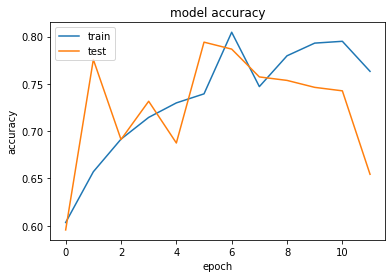

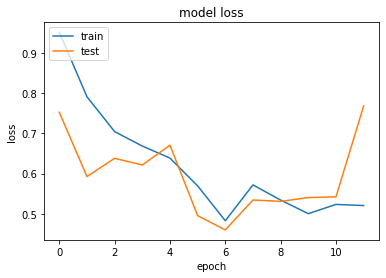

In [40]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob
import skimage
from skimage import io


def load_image(filename):
    img = skimage.io.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: limon_sano, file: limon_sano/img (339).png
PREDICTED: class: limon_podrido, confidence: 0.577940


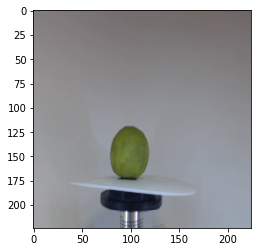

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_podrido, file: limon_podrido/img (562).png
PREDICTED: class: limon_podrido, confidence: 0.845122


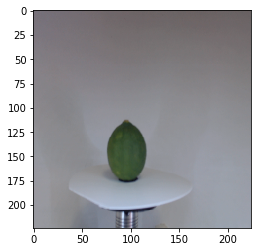

SOURCE: class: limon_manchado, file: limon_manchado/img (726).png
PREDICTED: class: limon_podrido, confidence: 0.610974


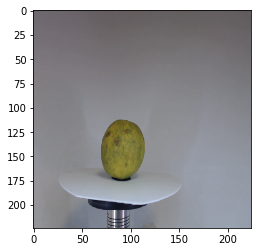

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_manchado, file: limon_manchado/img (722).png
PREDICTED: class: limon_podrido, confidence: 0.678615


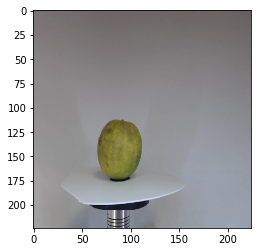

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_manchado, file: limon_manchado/img (731).png
PREDICTED: class: limon_sano, confidence: 0.931004


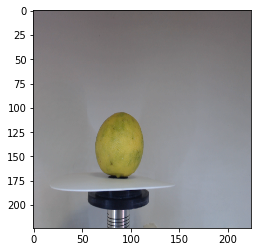

<Figure size 432x288 with 0 Axes>

In [42]:
import numpy as np

for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Transfer Learning Model with inception classification

In [0]:
#def define_model():
    #model = VGG16(include_top=False, input_shape=(224, 224, 3))
model=  tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v2/classification/4"),
                             #hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",trainable=True, arguments=dict(batch_norm_momentum=0.9)),
                             #tf.keras.layers.Dropout(0.1), 
                             tf.keras.layers.Dense(512, activation='sigmoid'),
                             tf.keras.layers.Dropout(rate=0.1), 
                             tf.keras.layers.Dense(512, activation='sigmoid'),
                             #tf.keras.layers.Dropout(rate=0.1), 
                             tf.keras.layers.Dense(train_generator.num_classes, activation='sigmoid')
                             ])

    #for layer in model.layers:
    #  layer.trainable = False
    #  #flat1 = Flatten()(model.layers[-1].output)
    #  class1 = Dense(512, activation='sigmoid', kernel_initializer='he_uniform', bias_initializer='zeros')(model.layers[-1].output)#(flat1)
    #  drop= Dropout(0.1)(class1)#
    #  output = Dense(3, activation='softmax')(drop)
    #  model = Model(inputs=model.inputs, outputs=output)
    #  opt = SGD(lr=0.001, momentum=0.9)
    #  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
   #   return model

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"} 
#0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
EPOCHS=50 #@param {type:"integer"}
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size, callbacks=[es])

Epoch 1/50
16/16 [==============================] - 25s 2s/step - loss: 0.9582 - acc: 0.6074 - val_loss: 0.8525 - val_acc: 0.6250
Epoch 2/50
16/16 [==============================] - 12s 729ms/step - loss: 0.8339 - acc: 0.6155 - val_loss: 0.9023 - val_acc: 0.6250
Epoch 3/50
16/16 [==============================] - 12s 729ms/step - loss: 0.7468 - acc: 0.6133 - val_loss: 0.8674 - val_acc: 0.6250
Epoch 4/50
16/16 [==============================] - 11s 694ms/step - loss: 0.7027 - acc: 0.6643 - val_loss: 0.8379 - val_acc: 0.6953
Epoch 5/50
16/16 [==============================] - 11s 657ms/step - loss: 0.7188 - acc: 0.6805 - val_loss: 0.7482 - val_acc: 0.7773
Epoch 6/50
16/16 [==============================] - 11s 660ms/step - loss: 0.6659 - acc: 0.6717 - val_loss: 0.6017 - val_acc: 0.7656
Epoch 7/50
16/16 [==============================] - 10s 645ms/step - loss: 0.6364 - acc: 0.7549 - val_loss: 0.5176 - val_acc: 0.7891
Epoch 8/50
16/16 [==============================] - 12s 722ms/step - los

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


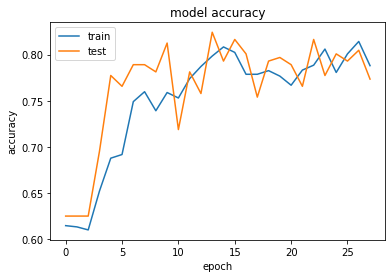

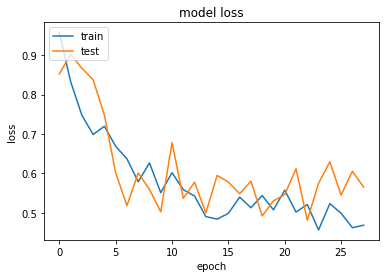

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

SOURCE: class: limon_manchado, file: limon_manchado/img (792).png
PREDICTED: class: limon_podrido, confidence: 0.530613


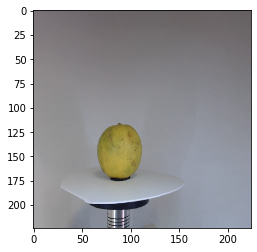

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_manchado, file: limon_manchado/img (739).png
PREDICTED: class: limon_podrido, confidence: 0.886371


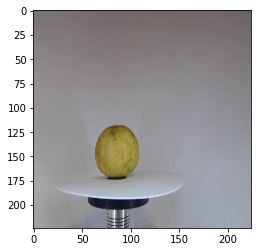

SOURCE: class: limon_podrido, file: limon_podrido/img (632).png
PREDICTED: class: limon_podrido, confidence: 0.820489


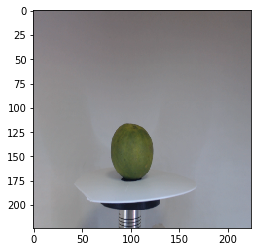

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_manchado, file: limon_manchado/img (769).png
PREDICTED: class: limon_sano, confidence: 0.922492


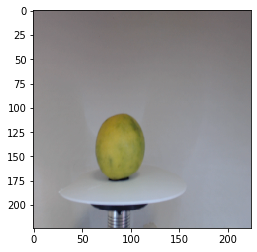

<Figure size 432x288 with 0 Axes>

SOURCE: class: limon_manchado, file: limon_manchado/img (762).png
PREDICTED: class: limon_podrido, confidence: 0.969415


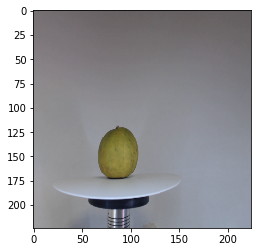

<Figure size 432x288 with 0 Axes>

In [43]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Images and CCI 

## Heatmap

In [0]:
import skimage
from skimage import io

img = skimage.io.imread(os.path.join(data_dir, "img (13).png"))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
heatmap_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)

### CCI

In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob


In [0]:
#for filename in glob.glob(r'C:\Users\caoti\Desktop\Lemon Images\Processed\miniset/*.png'):
 im = skimage.io.imread('img (1).png') # Cargamos y guardamos la imagen en turno
 plt.imshow(im)
 plt.title(filename)
 plt.show()
 im = im.reshape(-1,3) # Se cambian las dimensiones de la imagen de mxnx3 a (mxn)x3
 im.tolist() # Se cambia el tipo de dato de np.array a lista
 sl = [] # Una lista vacía que servirá de apoyo

    ### En este ciclo se calcula el CCI para cada tríada de píxeles de la imagen
    ### Si todos los valores son 0, entonces no ejecuta nada. Si no se cumple la
    ### condición, entonces se hace el cálculo.
    ### Al final del ciclo despliega el valor promedio del CCI

In [0]:
import numpy as np
import math
# import cv2 as cv

def rgb2Hunter(*args):
	"""Toma los pixles RGB de una imagen
	y devuelve los valores en XYZ """

	Xn = 95.0489
	Yn = 100
	Zn = 108.8840
	
	# Leemos la imagen
	# image = cv.imread(args)

	# Se cambian las dimensiones de la imagen
	# image.reshape(-1,3)

	# for i in image:
	for i in args:
		if all(i) == False:
			Hl = 0
			Ha = 0
			Hb = 0		
		else:
			# Se normalizan los canales RGB 
			vr = (i[2]) / 255
			vg = (i[1]) / 255
			vb = (i[0]) / 255

			# Las siguientes comparaciones se hacen para obtener
			# los valores de Vr, Vg y Vb respectivamente

			if vr > 0.04045:
				vr = ((vr + 0.055) / 1.055)**2.4
			else:
				vr = vr / 12.92
			if vg > 0.04045:
				vg = ((vg + 0.055) / 1.055)**2.4
			else:
				vg = vg / 12.92
			if vb > 0.04045:
				vb = ((vb + 0.055) / 1.055)**2.4
			else:
				vb = vb / 12.92

			vr = vr * 100
			vg = vg * 100
			vb = vb * 100

			xyz = np.array([vr,vg,vb])
			# Matriz de constantes para hacer la conversión
			m = np.array([
				[0.4124, 0.3576, 0.1805],
				[0.2126, 0.7152, 0.0722],
				[0.0193, 0.1192, 0.9505]])

			res = np.matmul(m,xyz) # Multiplicación de matrices

			# Valores en el espacio de color XYZ
			X = res[0]
			Y = res[1]
			Z = res[2]

			### Coversión de XYZ a Hunter Lab con base al estandar Illuminant D65
			### Los valores están declarados al inicio

			varKa = 172.349
			varKb = 67.039

			Hl = 100 * (Y/Yn)**0.5
			Ha = varKa * (((X/Xn) - (Y/Yn)) / math.sqrt(Y/Yn))
			Hb = varKb * (((Y/Yn) - (Z/Zn)) / math.sqrt(Y/Yn))

	return(Hl,Ha,Hb)

In [0]:
for j in im:
  h = rgb2Hunter(j)
  if all(h) == False:
    pass
  else:
      cci = (1000*h[1]) / (h[0]*h[2])
      sl.append(cci)
  #print(np.mean(sl))

In [0]:
print(np.mean(sl))
print(np.std(sl))

In [0]:
plt.imshow(img)
plt.show()

In [0]:
plt.imshow(gray_img,cmap='gray')
plt.show()

In [0]:
plt.imshow(heatmap_img)
plt.show()

In [0]:
plt.imshow(fin)
plt.show()

In [0]:
img = skimage.io.imread(os.path.join(data_dir, "img (5).png"))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
heatmap_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.7, img, 0.3, 0)

In [0]:
plt.imshow(img)
plt.show()

In [0]:
plt.imshow(gray_img,cmap='gray')
plt.show()

In [0]:
plt.imshow(heatmap_img)
plt.show()

In [0]:
plt.imshow(fin)
plt.show()

# References

[1] Serge Obam Y. (2019). Plant Disease Classification with TensorFlow Lite on Android. Source: https://medium.com/@yannicksergeobam/plant-disease-classification-with-tensorflow-2-0-268fe7f72c2a [Date: January 10th, 2020].